# Not Too Crazy Cap Table Math
- Author: James Behzadi (Co-founder of [kintell.com](https://kintell.com/advisors/james-behzadi/not-too-crazy-cap-table-math))
- To understand the code, I recommend watching this video first (link [here](https://youtu.be/Dk6JNTDec9I)).

## Disclaimer:
- I am not taking any responsibility for you using this. I only share this with an educational mindset on an 'as it is' basis to help founders to get their head around cap table math.

### Conversion at SAFE Price
Example 1 (item 2) of Appendix II (page 18, link [here](https://www.ycombinator.com/docs/Post%20Money%20Safe%20User%20Guide.pdf))
- Both SAFEs convert at Safe price as the post-money valuation is far enough from the SAFE caps

Series Seed price per share ($) =  1.11447302068
Company Capitalisation (fully-diluted) =  17945701.3575
Founders % Reduction =  48.4556227937


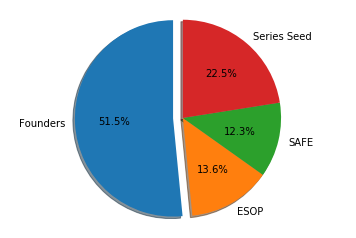

,Entity,SAFE Raise,SAFE Cap,Discount %,Pre-SAFE %,Post-SAFE %,SAFE Shares,Conversion,Final Shares,Fully-Diluted %
0,SAFE A,200000,4e+06,-,-,5,588235,Safe price,5.882353e+05,3.277862
1,SAFE B,800000,8e+06,-,-,10,1.17647e+06,Safe price,1.625113e+06,9.055724
2,SAFE C,0,-,15,-,0,0,discount,0.000000e+00,0.000000
3,Series Seed,-,-,-,-,-,-,-,4.037783e+06,22.500000
4,Early Hires,-,-,-,6.5,5.525,650000,-,6.500000e+05,3.622037
5,Options Available,-,-,-,1,0.85,100000,-,1.794570e+06,10.000000
6,Founders,-,-,-,92.5,78.625,9.25e+06,-,9.250000e+06,51.544377


In [11]:
# Model inputs
dic = {
    "raiseA" : 5e6,
    "preM" : 15e6,
    "newEsopPer100" : 10,
    "raiseSAFE_a" : 200e3,
    "safeCap_a" : 4e6,
    "proRata_a" : False,
    "raiseSAFE_b" : 800e3,
    "safeCap_b" : 8e6,
    "proRata_b" : True,
    "raiseSAFE_c" : 0,
    "discountPer100_c" : 15,
    "proRata_c" : False,
    "proRataCap_c" : 100e3, # Investor C's pro rata is capped
    "earlyHiresPer100" : 6.5,
    "preSafeShares" : 10e6,
    "preSafeESOP" : 100e3    # available options before SAFEs
}
_, df, _ = capTableMath(dic, True); df

### Conversion at higer price
Example 1 (item 5) of Appendix II (page 21, link [here](https://www.ycombinator.com/docs/Post%20Money%20Safe%20User%20Guide.pdf))
- One of the SAFEs converts at the Safe price and the other one at Seed round price per share

Series Seed price per share ($) =  0.657879977566
Company Capitalisation (fully-diluted) =  16720375.1066
Founders % Reduction =  44.6782746138


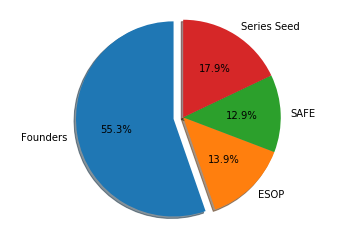

,Entity,SAFE Raise,SAFE Cap,Discount %,Pre-SAFE %,Post-SAFE %,SAFE Shares,Conversion,Final Shares,Fully-Diluted %
0,SAFE A,200000,4e+06,-,-,4.98324,588235,Safe price,5.882353e+05,3.518075
1,SAFE B,800000,8e+06,-,-,10.3016,1.21603e+06,Seed price,1.560520e+06,9.333046
2,SAFE C,0,-,15,-,0,0,discount,0.000000e+00,0.000000
3,Series Seed,-,-,-,-,-,-,-,2.999582e+06,17.939681
4,Early Hires,-,-,-,6.5,5.50649,650000,-,6.500000e+05,3.887473
5,Options Available,-,-,-,1,0.847152,100000,-,1.672038e+06,10.000000
6,Founders,-,-,-,92.5,78.3615,9.25e+06,-,9.250000e+06,55.321725


In [12]:
dic['raiseA'] = 2.2e6; dic['preM'] = 8.8e6
_, df, _ = capTableMath(dic, True); df

## Model Inputs
- First run the following two cells and then the ones at the top :)

### Some boring functions to do the math & graphs

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import numpy as np
from scipy.optimize import fsolve


def safeCalcs(sAprice, *data):
    safeCap_a, safeCap_b, discountPer100_c, raiseSAFE_a, raiseSAFE_b, raiseSAFE_c, preSafeShares = data  # automatic unpacking, no need for the 'i for i'
    
    expectedSafePer100_a = raiseSAFE_a / safeCap_a * 100
    expectedSafePer100_b = raiseSAFE_b / safeCap_b * 100
    expectedSafePer100 = expectedSafePer100_a + expectedSafePer100_b

    safeShares_c = raiseSAFE_c / (sAprice * (1-discountPer100_c/100))
    postSafeSharesTmp = (preSafeShares + safeShares_c) / (1-expectedSafePer100/100)
    
    convMethod_a, safeShares_a = getSafeMethod(sAprice, safeCap_a, raiseSAFE_a, postSafeSharesTmp)
    convMethod_b, safeShares_b = getSafeMethod(sAprice, safeCap_b, raiseSAFE_b, postSafeSharesTmp)
        
    if convMethod_a == 'Safe price' and convMethod_b == 'S-A price':
        safeShares_a = expectedSafePer100_a/100 * (preSafeShares + safeShares_b + safeShares_c) / (1 - expectedSafePer100_a/100)
    elif convMethod_a == 'S-A price' and convMethod_b == 'Safe price':
        safeShares_b = expectedSafePer100_b/100 * (preSafeShares + safeShares_a + safeShares_c) / (1 - expectedSafePer100_b/100)
        
    safeShares = safeShares_a + safeShares_b + safeShares_c
    postSafeShares = preSafeShares + safeShares
    
    df = pd.DataFrame(OrderedDict((
        ('Entity', ['SAFE A', 'SAFE B', 'SAFE C']),
        ('SAFE Raise', [raiseSAFE_a, raiseSAFE_b, raiseSAFE_c]),
        ('SAFE Cap', [safeCap_a, safeCap_b, '-']),
        ('Discount %', ['-', '-', discountPer100_c]),
        ('Pre-SAFE %', ['-', '-', '-']),
        ('Post-SAFE %', [safeShares_a/postSafeShares*100, safeShares_b/postSafeShares*100, safeShares_c/postSafeShares*100]),
        ('SAFE Shares', [safeShares_a, safeShares_b, safeShares_c]),
        ('Conversion', [convMethod_a, convMethod_b, 'discount'])
        )))
    return df, safeShares

def proRataCalcs(proRata_a, proRata_b, df, sAshares, finalCap, *data_c):
    # pro rata calculations
    sAshares_d = sAshares
    
    proRata_c, proRataCap_c, sAprice, discountPer100_c = data_c

    postSAFEper100_a = df.iloc[0]['Post-SAFE %']
    safeShares_a = df.iloc[0]['SAFE Shares']
    if proRata_a:
        proRataShares_a = postSAFEper100_a/100 * sAshares
    else:
        proRataShares_a = 0
    sAshares_a = safeShares_a + proRataShares_a
    
    postSAFEper100_b = df.iloc[1]['Post-SAFE %']
    safeShares_b = df.iloc[1]['SAFE Shares']
    if proRata_b:
        proRataShares_b = postSAFEper100_b/100 * sAshares
    else:
        proRataShares_b = 0
    sAshares_b = safeShares_b + proRataShares_b
    
    postSAFEper100_c = df.iloc[2]['Post-SAFE %']
    safeShares_c = df.iloc[2]['SAFE Shares']
    if proRata_c:
        proRataShares_c1 = postSAFEper100_c/100 * sAshares
        proRataShares_c2 = proRataCap_c / (sAprice * (1-discountPer100_c/100))
        proRataShares_c = max(proRataShares_c1, proRataShares_c2)
    else:
        proRataShares_c = 0
    sAshares_c = safeShares_c + proRataShares_c

    
    sAshares_d = sAshares - proRataShares_a - proRataShares_b - proRataShares_c

    df.loc[3] = ['Series Seed', '-', '-', '-', '-', '-', '-', '-']
    df['Final Shares'] = [sAshares_a, sAshares_b, sAshares_c, sAshares_d]
    df['Fully-Diluted %'] = [sAshares_a/finalCap*100, sAshares_b/finalCap*100, sAshares_c/finalCap*100, sAshares_d/finalCap*100]
    
    return df

def getSafeMethod(
    sAprice, safeCap, raiseSAFE, postSafeSharesTmp
):
    shareMethod1 = raiseSAFE / safeCap * postSafeSharesTmp
    shareMethod2 = raiseSAFE / sAprice

    if shareMethod1 > shareMethod2:
        convMethod = 'Safe price'
        safeShares = shareMethod1
    else:
        convMethod = 'Seed price'
        safeShares = shareMethod2
    
    return convMethod, safeShares     

def f(sAprice, *dataIn):
    raiseA, postM, esopVal, safeCap_a, safeCap_b, discountPer100_c, raiseSAFE_a, raiseSAFE_b, raiseSAFE_c, proRata_a, proRata_b, proRata_c, proRataCap_c, preSafeESOP, preSafeShares = dataIn  # automatic unpacking
    
    data = (safeCap_a, safeCap_b, discountPer100_c, raiseSAFE_a, raiseSAFE_b, raiseSAFE_c, preSafeShares)
    df, safeShares = safeCalcs(sAprice, *data)
    
    postSafeCap = preSafeShares + safeShares
    sAshares = raiseA / sAprice
    esopShares = esopVal / sAprice
    finalCap = postSafeCap + (esopShares - preSafeESOP) + sAshares
    
    # pro rata calcs
    data_c = proRata_c, proRataCap_c, sAprice, discountPer100_c
    df = proRataCalcs(proRata_a, proRata_b, df, sAshares, finalCap, *data_c)
        
    expectedSeriesAper100 = raiseA / postM
    trueSeriesAper100 = sAshares / finalCap
    dif = trueSeriesAper100 - expectedSeriesAper100
    return dif

def sApriceCalcs(dic):
    # Iterative calcs to find price per share for Series Seed
    data = dic['raiseA'], dic['postM'], dic['esopVal'], dic['safeCap_a'], dic['safeCap_b'], dic['discountPer100_c'], dic['raiseSAFE_a'], dic['raiseSAFE_b'], dic['raiseSAFE_c'], dic['proRata_a'], dic['proRata_b'], dic['proRata_c'], dic['proRataCap_c'], dic['preSafeESOP'], dic['preSafeShares']
    tmp = fsolve(f, .8, args=data)
    return tmp[0]

def capTableMath(dic, verbose):
    
    # update computed values
    computedVals(dic)
    
    # iterative calculation of Series Seed price per share
    sAprice = sApriceCalcs(dic)

    # SAFE calcs
    data = dic['safeCap_a'], dic['safeCap_b'], dic['discountPer100_c'], dic['raiseSAFE_a'], dic['raiseSAFE_b'], dic['raiseSAFE_c'], dic['preSafeShares']
    df, safeShares = safeCalcs(sAprice, *data)
    preSafeCap = dic['preSafeShares']
    postSafeCap = preSafeCap + safeShares

    # new money calcs
    sAshares = dic['raiseA'] / sAprice
    esopShares = dic['esopVal'] / sAprice
    
    finalCap = postSafeCap + (esopShares - dic['preSafeESOP']) + sAshares
    
    # pro rata calcs
    data_c = dic['proRata_c'], dic['proRataCap_c'], sAprice, dic['discountPer100_c']
    df = proRataCalcs(dic['proRata_a'], dic['proRata_b'], df, sAshares, finalCap, *data_c)
    
    # do the math
    a4 = dic['earlyHiresShares']
    a5a = dic['preSafeESOP']; a5b = esopShares
    a6 = dic['foundersShares']
    df.loc[4] = ['Early Hires', '-', '-', '-', a4/preSafeCap*100, a4/postSafeCap*100, a4, '-', a4, a4/finalCap*100]
    df.loc[5] = ['Options Available', '-', '-', '-', a5a/preSafeCap*100, a5a/postSafeCap*100, a5a, '-', a5b, a5b/finalCap*100]
    df.loc[6] = ['Founders', '-', '-', '-', a6/preSafeCap*100, a6/postSafeCap*100, a6, '-', a6, a6/finalCap*100]

    
    capTable = {
        "safes" : (df.iloc[0]['Final Shares'] + df.iloc[1]['Final Shares'] + df.iloc[2]['Final Shares']) / finalCap,
        "sA" : df.iloc[3]['Final Shares'] / finalCap,
        "esop" : (df.iloc[4]['Final Shares'] + df.iloc[5]['Final Shares']) / finalCap,
        "founders" : df.iloc[6]['Final Shares'] / finalCap
    }
    
    # foundersDilution = 100 * dic['foundersShares'] * (1.0 / dic['preSafeShares'] - 1.0 / finalCap)
    foundersDilution = 100*(1 - dic['foundersShares'] / finalCap)
    if verbose:
        print('Series Seed price per share ($) = ', sAprice)
        print('Company Capitalisation (fully-diluted) = ', finalCap)
        print('Founders % Reduction = ', foundersDilution)

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = 'Founders', 'ESOP', 'SAFE', 'Series Seed'
        sizes = [capTable['founders'], capTable['esop'], capTable['safes'], capTable['sA']]
        explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        plt.show()
    
    return capTable, df, foundersDilution

def computedVals(dic):
    dic['postM'] = dic['raiseA'] + dic['preM']
    dic['esopVal'] = dic['newEsopPer100']/100 * dic['postM']
    dic['foundersShares'] = (1-dic['earlyHiresPer100']/100) * dic['preSafeShares'] - dic['preSafeESOP']
    dic['earlyHiresShares'] = dic['earlyHiresPer100']/100 * dic['preSafeShares']
    return

def valuationSensitivity(dic, raiseA, newEsopPer100, title):
    dic['raiseA'] = raiseA
    dic['newEsopPer100'] = newEsopPer100
    founders = []; sA = []; postM = []; foundersDilution = []
    x = range(6, 12)
    for preM in x:
        dic['preM'] = preM * 1e6
        capTable, _, temp = capTableMath(dic, False)
        founders.append(capTable['founders']*100)
        sA.append(capTable['sA']*100)
        postM.append(dic['postM']/1e6)
        foundersDilution.append(temp)

    # data
    df = pd.DataFrame(OrderedDict(
        (('post-money', postM), ('% founders', founders), ('% series-Seed', sA), ('% reduction', foundersDilution))))
    plotter(df, 'post-money', 'Post Money Valuation (milion $)', title)

    return df

def raiseSensitivity(dic, preM, newEsopPer100, title):
    dic['preM'] = preM
    dic['newEsopPer100'] = newEsopPer100
    founders = []; sA = []; raiseA = []; foundersDilution = []
    x = np.arange(2.0, 3.2, .2)
    for raiseA in x:
        dic['raiseA'] = raiseA * 1e6
        capTable, _, temp = capTableMath(dic, False)
        founders.append(capTable['founders']*100)
        sA.append(capTable['sA']*100)
        foundersDilution.append(temp)

    # data
    df = pd.DataFrame({'Seed Raise': x, '% founders': founders, '% series-Seed': sA, '% reduction' : foundersDilution})
    plotter(df, 'Seed Raise', 'Series Seed raise (milion $)', title)

    return df

def plotter(df, x, xlabel, title):
    # multiple line plot
    plt.plot( x, '% founders', data=df, marker='o', markerfacecolor='pink', markersize=12, color='skyblue', linewidth=4)
    plt.plot( x, '% series-Seed', data=df, marker='o', markerfacecolor='skyblue', markersize=12, color='pink', linewidth=4)
    plt.plot( x, '% reduction', data=df, marker='o', markerfacecolor='grey', markersize=12, color='lightgrey', linewidth=4)
    plt.legend(loc='center right')
    plt.grid(b=True, which='major', color='grey', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel('%')
    plt.title(title)
    plt.show()
    return